## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device ='cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw




Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw




Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw




Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [20]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.BatchNorm1d(input_shape, affine=False, momentum=0.2),
            nn.Linear(input_shape, 300),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.BatchNorm1d(50, momentum=0.2),
            nn.ReLU(),
            nn.Linear(50, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

RuntimeError: ignored

Your experiments come here:

In [21]:
model = TinyNeuralNetwork().to(device)
opt =  torch.optim.Adam(model.parameters(), lr=0.1)# YOUR CODE HERE
loss_func = nn.NLLLoss()# YOUR CODE HERE

# Your experiments, training and validation loops here
def train(model, opt, loss_func):
    model.train(True)
    for i in range(30):
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            opt.zero_grad()
            preds = model.forward(x_batch)
            loss = loss_func(preds, y_batch.long())
            loss.backward()
            opt.step()

train(model, opt, loss_func)

In [22]:
from sklearn.metrics import accuracy_score
def accuracy(model, dataset):
    for x_batch, y_batch in dataset:
        probs = model.forward(x_batch).detach().numpy()
        argmax = np.argmax(probs, axis=1)
    return accuracy_score(argmax, y_batch.detach().numpy())
    
print("The accuracy: {}".format(accuracy(model, test_loader)))


The accuracy: 0.875


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [23]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 400),
            nn.ReLU(),
            nn.Linear(400, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

RuntimeError: ignored

In [24]:
batch_indices = list(range(0, len(fmnist_dataset_train), 10))

train_subset = torch.utils.data.Subset(fmnist_dataset_train, batch_indices)

train_loader_subset = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)

def train_model(model, train_loader, test_loader, loss_fn, opt, n_epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_train_accuracy = []
        ep_test_loss = []
        ep_test_accuracy = []
        model.train(True)        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            opt.zero_grad()
            preds = model.forward(X_batch)
            loss = loss_func(preds, y_batch.long())
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())
            ep_train_accuracy.append(accuracy_score(np.argmax(preds.detach().numpy(), axis=1), y_batch.detach().numpy()))
        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = model.forward(X_batch)                
                ep_test_loss.append(loss_func(preds, y_batch.long()).item())
                ep_test_accuracy.append(accuracy_score(np.argmax(preds, axis=1), y_batch.detach().numpy()))
        train_loss.append(np.mean(ep_train_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))
        test_loss.append(np.mean(ep_test_loss))
        test_accuracy.append(np.mean(ep_test_accuracy))
    return train_loss, train_accuracy, test_loss, test_accuracy



In [25]:

model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.8)
loss_func = nn.NLLLoss()

train_loss, train_accuracy, test_loss, test_accuracy = train_model(model, train_loader_subset, test_loader, loss_func, opt, 300)

# Your experiments, come here

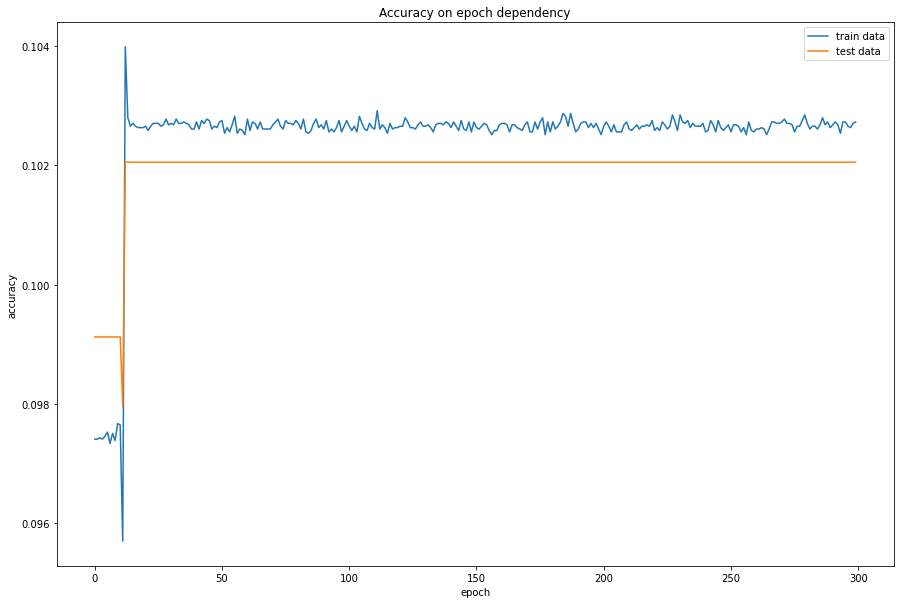

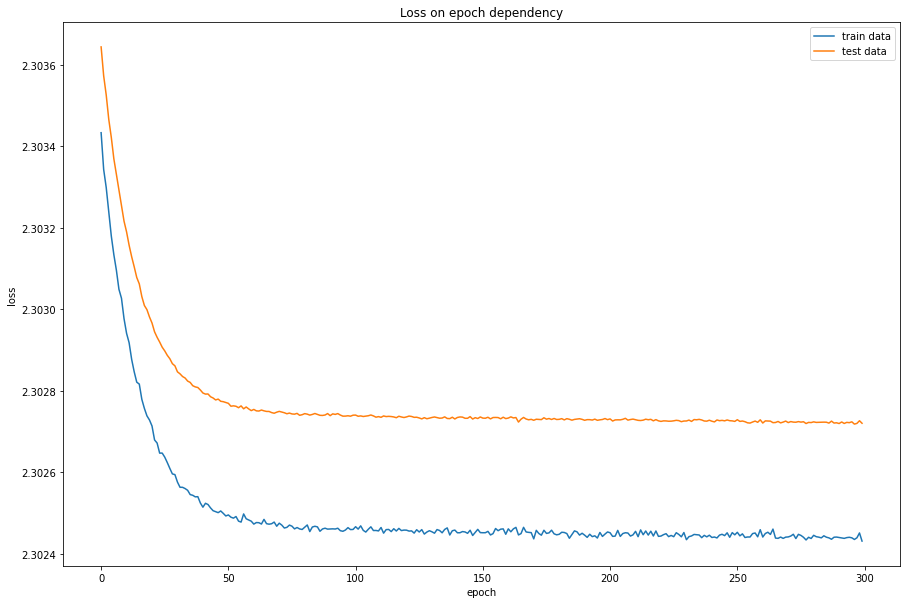

In [26]:
def draw_plot_accuracy():
    plt.figure(figsize=(15, 10))
    plt.title("Accuracy on epoch dependency")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.plot(train_accuracy, label='train data')
    plt.plot(test_accuracy, label='test data')
    plt.legend()
    plt.show()
def draw_plot_loss():
    plt.figure(figsize=(15, 10))
    plt.title("Loss on epoch dependency")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_loss, label='train data')
    plt.plot(test_loss, label='test data')    
    plt.legend()
    plt.show()
draw_plot_accuracy()
draw_plot_loss()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [27]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Dropout(p=0.2),
            nn.BatchNorm1d(input_shape, affine=False),
            nn.Linear(input_shape, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200, affine=False),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes),
            nn.LogSoftmax(dim=1)
            
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.8)
loss_func = nn.NLLLoss()

train_loss_fixed, train_accuracy_fixed, test_loss_fixed, test_accuracy_fixed = train_model(model, train_loader_subset, test_loader, loss_func, opt, 300)

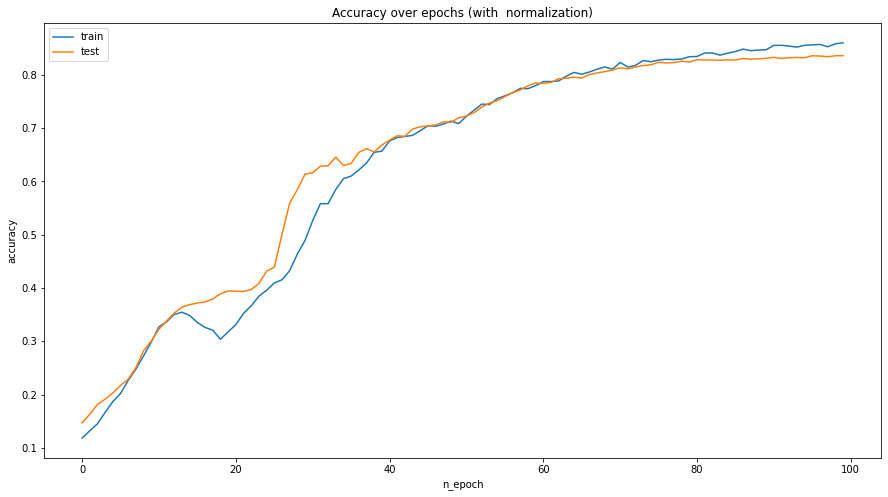

In [28]:
plt.figure(figsize=(15, 8))
plt.title("Accuracy over epochs (with  normalization)")
plt.xlabel("n_epoch")
plt.ylabel("accuracy")

plt.plot(train_accuracy_fixed, label='train')
plt.plot(test_accuracy_fixed, label='test')
    
plt.legend()
plt.show()

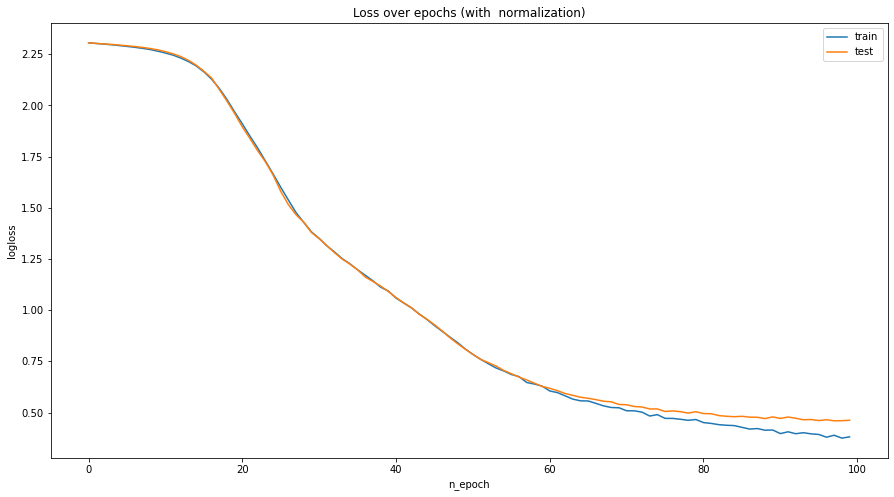

In [29]:
plt.figure(figsize=(15, 8))
plt.title("Loss over epochs (with  normalization)")
plt.xlabel("n_epoch")
plt.ylabel("logloss")

plt.plot(train_loss_fixed, label='train')
plt.plot(test_loss_fixed, label='test')
    
plt.legend()
plt.show()

### Conclusions:
_Write down small report with your conclusions and your ideas._

In this part of lab work we were supposed to create some Neural Networks and learn their behaviour depending on the sequence of layers. We have created three networks. Lets shortly redescribe them

1)TinyNeuralNetwork

Just a basic Neural Network that pretends to show a good results on the given dataset.

2) OverfittingNeuralNetwork

Has properly the same structer as the previous one, but has pretty more layers which means the high chance for network to "remember" all the dataset and show much worse result on the test data.

3) FixedNeuralNetwork

Has the same structer as the previous one, but uses regulazation (Dropout and Batchnorm) that really improves results at the test data.


To sum up, the result accuracy of the Neural Network depends on both number of layers and usage of regulazation. The examples bellow show that combination of proper(or slightly higher) number of layers and Dropout/Batchnorm or some other kinds of regularization do a big impact in an efficiency of the result model.